# 09.04 People

SVMs are good for image recognition because of the high dimensional space,
i.e. one dimension per pixel in the image.
We will attempt to classify a dataset of faces.
A face is a non-linear problem.
For example we can tell that these two characters are related
because the same actor did play them.
But the only relation is the face,
and perhaps the overly muscular body,
the characters themselves have very little in common.

![Characters](sl-stallone.svg)

<div style="text-align:right;"><sup>sl-stallone.svg</sup></div>

We import the usual things and the SVM classifier.
Also we import the loader for the Olivetti faces.
The Olivetti faces is a set of $400$ images of faces, $10$ faces per person.
It is a very clean dataset: the faces are well centered and the *support*
of each class is the same across all classes.
And since we are working with images we import PCA for noise reductions
and model selection tools.

In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import fetch_olivetti_faces

ofaces = fetch_olivetti_faces()
print(ofaces.DESCR)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/mike/scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some

We should also look at the images to see what we are working with.

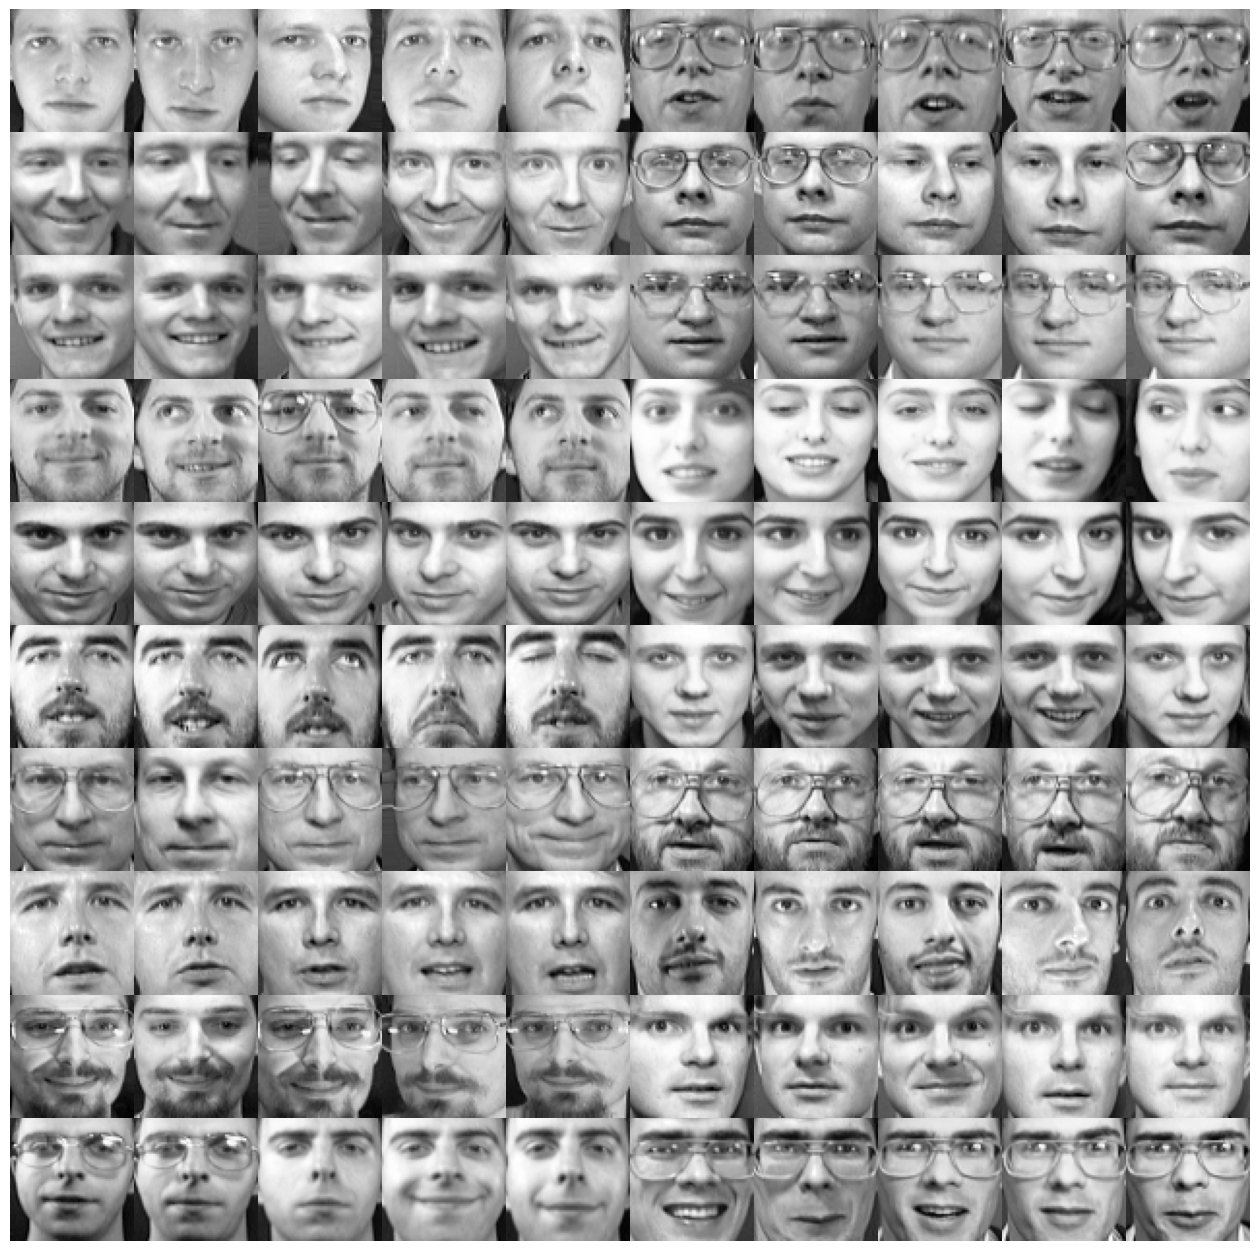

In [2]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16))
fig.subplots_adjust(hspace=0, wspace=0)
for i, ax in enumerate(axes.flat):
    ax.imshow(ofaces.images[i*2], cmap='gray')
    ax.axis('off')

We can certainly see what was the glasses trend in the early $1990$s!

This dataset is very ordered, each person's faces (class) are next to each other.
If we will want to do cross validation we will need to shuffle it first,
that is what `KFold` allows us to do.
One peculiar thing about the `GridSearchCV` we will use is the kernel setting.
Instead of a plain dictionary we provide a list
and within the list we have the dictionaries for each kernel for the SVM.
Here we try different kernels, and each requires a different set of hyperparameters.
The `gamma` hyperparameter is the letter $\eta$ in our `rbf` kernel definition,
which letter is used in which notation often changes, beware!

Remember that a double underscore is a bridge between the
part of the pipeline and the hyperparameter name to set.
If one looks inside the `sklearn` objects the underscores naming convention
is accomplished by clever processing inside the `set_params` method,
a method that exists in each model object in `sklearn`.
The double underscore means to invoke `set_params` on the attribute named
before the double underscore,
and it can be repeated many times when dealing with deep pipelines.

The following will take a while to complete when run.

In [3]:
model = make_pipeline(PCA(n_components=128, svd_solver='randomized'), SVC())
strategy = KFold(n_splits=5, shuffle=True)
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000, 10000]},
    {'svc__kernel': ['rbf'], 'svc__C': [1, 10, 1000, 10000], 'svc__gamma': [0.001, 0.1, 1.0, 10.0]}
]
grid = GridSearchCV(model, param_grid, cv=strategy)
grid.fit(ofaces.data, ofaces.target)
grid.best_score_, grid.best_estimator_

(np.float64(0.9650000000000001),
 Pipeline(steps=[('pca', PCA(n_components=128, svd_solver='randomized')),
                 ('svc', SVC(C=1000, gamma=0.001))]))

That is a pretty good score.
SVMs are a good method for classifying images.
And we also see what hyperparameters were used, throughout the best pipeline.

The $C$ hyperparameter of an SVM is its tolerance to data points inside the support vectors.
A smaller $C$ results in a model with better generalization
(better at classifying unknown data) because it is less sensitive to noise in the data.
Yet, a too small $C$ will undefit the data.

But we cannot really know the actual generalization score for these hyperparameters.
This is because we tuned the hyperparameters against all data.
This is hyperparameter overfit is a problem we will tackle next.

### Multiclass SVMs

But before going forward, have you noticed something strange?
I just told you that an SVM draws a (hyper)plane between two classes but we just
classified $40$ different classes.
What magic is happening here?

In reality we have trained $40$ different SVMs, one for each class.
An SVM is a **binary classifier**, i.e. it can only classify between two classes,
often called the *negative class* and the *positive class*.
What the Support Vector Classifier (`SVC`) performs is a technique called *One vs All*
(OVA, or OVR - *One vs Rest*), in which it trains an SVM with the class
as the positive class and all other data points as the negative class.
The final prediction it the class that is further away from its own decision line,
i.e. from all classifiers that consider a new data point as its positive class
the `SVC` selects the SVM which is more confident about its result.

*One vs One* (OVO) is another technique to make a binary classifier work on several classes.
Whilst OVA trains a classifier for each class OVA trains a classifier for each pair of classes.
The prediction is then done by majority voting across the SVMs.

OVO trains more classifiers but OVA trains all classifiers on the full dataset.
For example, above we would have trained $780$ different SVMs,
one for each pair of classes $(combination(40, 2) = 780)$.
For SVMs OVO is faster when there is a lot of data because an SVM takes much
longer to train when the amount of data increases,
i.e. training more small SVMs is faster than a few big SVMs.

![OVO vs OVA](sl-ovo-ova.svg)

<div style="text-align:right;"><sup>sl-ovo-ova.svg</sup></div>

Note that when we used a Logistic Regression to classify four different moons,
behind the scenes `sklearn` has also used a One vs All trick.
A Logistic Regression is a binary classifier after all.

## References

- [SciKit Learn - Face Decomposition][1]

[1]: https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html